In [ ]:
# Import basic libraries
import os
import zipfile
import warnings
warnings.filterwarnings('ignore')
# Data manipulation and processing
import numpy as np
import pandas as pd
# Audio processing
import librosa
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Progress bar
from tqdm import tqdm
# Machine learning and metrics
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report
# TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
# Display
import IPython

print('Done!')

Done!


#**Kaggle Dataset Loading and Extraction in Google Colab**

#####Dataset link:  https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition/data

In [ ]:
!pip install kaggle

Download the kaggle.json file from the following address and then upload it. https://www.kaggle.com/

Log into your Kaggle account, go to the settings section, and under the API section, click on "Create New Token" to download the kaggle.json file. Never share this file with anyone!

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

dataset_name = "birdy654/deep-voice-deepfake-voice-recognition"
api.dataset_download_files(dataset_name)

Dataset URL: https://www.kaggle.com/datasets/birdy654/deep-voice-deepfake-voice-recognition


unzip dataset:

In [ ]:
import zipfile
# extraction of train and test data from zipfiles to data folder
extract_path = '/content/dataset/'
zip_file_path = '/content/deep-voice-deepfake-voice-recognition.zip'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(' Extraction is completed\n')

 Extraction is completed



In [ ]:
# Define paths for audio files:
audio_path = '/content/dataset/KAGGLE/AUDIO'

real_audio_path = '/content/dataset/KAGGLE/AUDIO/REAL'
fake_audio_path = '/content/dataset/KAGGLE/AUDIO/FAKE'

real_audio = "/content/dataset/DEMONSTRATION/DEMONSTRATION/linus-original-DEMO.mp3"
fake_audio = "/content/dataset/DEMONSTRATION/DEMONSTRATION/linus-to-musk-DEMO.mp3"

data_path = "/content/dataset/KAGGLE/DATASET-balanced.csv"

In [ ]:
folders = os.listdir(audio_path)
print(folders)

['FAKE', 'REAL']


In [ ]:
# Playing the real audio clip of Linus Sebastian
print('Real Audio:')
IPython.display.Audio(real_audio)

Real Audio:


In [ ]:
# Playing the fake audio clip of the transformed voice resembling Elon Musk
print('Fake Audio:')
IPython.display.Audio(fake_audio)

Fake Audio:


# Loading and preparing the data

In [ ]:
#Read audio data from a CSV file
audio_data = pd.read_csv(data_path)
audio_data.head()

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.338055  0.027948        2842.948867         4322.916759  6570.586186   
1     0.443766  0.037838        2336.129597         3445.777044  3764.949874   
2     0.302528  0.056578        2692.988386         2861.133180  4716.610271   
3     0.319933  0.031504        2241.665382         3503.766175  3798.641521   
4     0.420055  0.016158        2526.069123         3102.659519  5025.077899   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.041050 -462.169586   90.311272  19.073769  24.046888  ...   
1            0.047730 -409.413422  120.348808  -7.161531   5.114784  ...   
2            0.080342 -318.996033  120.490273 -24.625771  23.891073  ...   
3            0.047180 -404.636749  136.320908   2.308172  -3.907071  ...   
4            0.051905 -410.497925  152.731400 -18.266771  51.993462  ...   

     mfcc12    mfcc13    mfcc14    mfcc15    mfcc16    mfcc17    mfcc18  \
0 -6.686564  0.902086 -7.251551 -1.198342  4.747403 -4.986279  0.953935   
1 -2.131157 -6.876417 -1.359395  0.326401 -5.420016 -2.109968 -1.757634   
2 -5.853725 -3.724773 -6.627182 -5.117002 -6.072106 -0.994653 -1.617120   
3 -1.898315 -2.046493 -7.176277 -3.293508  4.209121  0.121835 -5.407063   
4 -1.952340  0.810868  6.238493  6.555839  7.535542  2.849219  2.616843   

     mfcc19    mfcc20  LABEL  
0 -5.013138 -6.779060   FAKE  
1 -9.537907 -8.494421   FAKE  
2 -3.922354 -7.033001   FAKE  
3 -3.654926 -3.274857   FAKE  
4 -1.793357 -5.060998   FAKE  

[5 rows x 27 columns]

In [ ]:
#encode categorical labels
label_encoder = LabelEncoder()
audio_data['LABEL'] = label_encoder.fit_transform(audio_data['LABEL'])

In [ ]:
# Shuffle the rows of the DataFrame to randomize the order of instances
audio_data = audio_data.sample(frac=1).reset_index(drop=True)
audio_data.head()

chroma_stft       rms  spectral_centroid  spectral_bandwidth      rolloff  \
0     0.378615  0.108536        1001.458697         1356.174541  1767.963105   
1     0.418494  0.018572        4612.864863         3663.844890  8195.313064   
2     0.456136  0.041911        2953.552656         3348.418425  6251.492834   
3     0.327958  0.052019        2860.281086         3231.377145  5082.479100   
4     0.432086  0.032589        2324.465493         2203.512273  3679.587978   

   zero_crossing_rate       mfcc1       mfcc2      mfcc3      mfcc4  ...  \
0            0.028334 -294.141571  210.736588   3.324903 -14.189301  ...   
1            0.141949 -364.020447   80.085625 -37.058781  56.435661  ...   
2            0.079811 -319.112671  116.803955 -19.118284   7.669029  ...   
3            0.075942 -324.252747  109.177444 -17.173573   9.849094  ...   
4            0.088360 -262.241974  164.996567 -87.472992   8.300056  ...   

     mfcc12    mfcc13     mfcc14    mfcc15    mfcc16     mfcc17     mfcc18  \
0 -3.741118 -0.020167   3.244040  3.289988  3.531686  -0.322002  -3.219230   
1 -5.957458 -6.571320 -11.809927 -1.736168 -5.420871  -5.889353 -13.726351   
2 -4.014131 -2.615798 -11.118894 -6.221027 -9.136768  -3.027375  -5.048083   
3 -5.002306 -2.360152 -11.646350 -9.179656  4.654444  -1.789754   2.028404   
4 -9.583906 -2.190576 -11.897200  3.179783  1.408431 -16.058064  -1.478592   

     mfcc19     mfcc20  LABEL  
0  3.316036   5.080199      1  
1  0.536994 -18.209732      1  
2 -1.981890  -2.332838      0  
3 -8.373720  -9.223312      0  
4 -4.724536   6.238822      0  

[5 rows x 27 columns]

In [ ]:
# 'X' will store our features, while 'y' will hold the ground-truth labels.
X = audio_data.iloc[:,:-1] # Features
y = audio_data.iloc[:,-1] # Labels

In [ ]:
print(y.head(10))

0    1
1    1
2    0
3    0
4    0
5    0
6    1
7    0
8    1
9    0
Name: LABEL, dtype: int64


In [ ]:
X.iloc[500]

chroma_stft              0.537752
rms                      0.019957
spectral_centroid     3042.041922
spectral_bandwidth    3695.712615
rolloff               6473.901508
zero_crossing_rate       0.075638
mfcc1                 -397.713074
mfcc2                  135.837585
mfcc3                  -10.583462
mfcc4                   30.558077
mfcc5                    4.184983
mfcc6                   22.851236
mfcc7                  -15.006731
mfcc8                    6.228925
mfcc9                   -7.701502
mfcc10                  -6.101829
mfcc11                   0.086243
mfcc12                   0.751118
mfcc13                  -3.923601
mfcc14                  -1.112120
mfcc15                  -1.056640
mfcc16                   2.629498
mfcc17                  -1.070511
mfcc18                  -6.128715
mfcc19                   4.745981
mfcc20                  -3.362852
Name: 500, dtype: float64

In [ ]:
y.iloc[500]

0

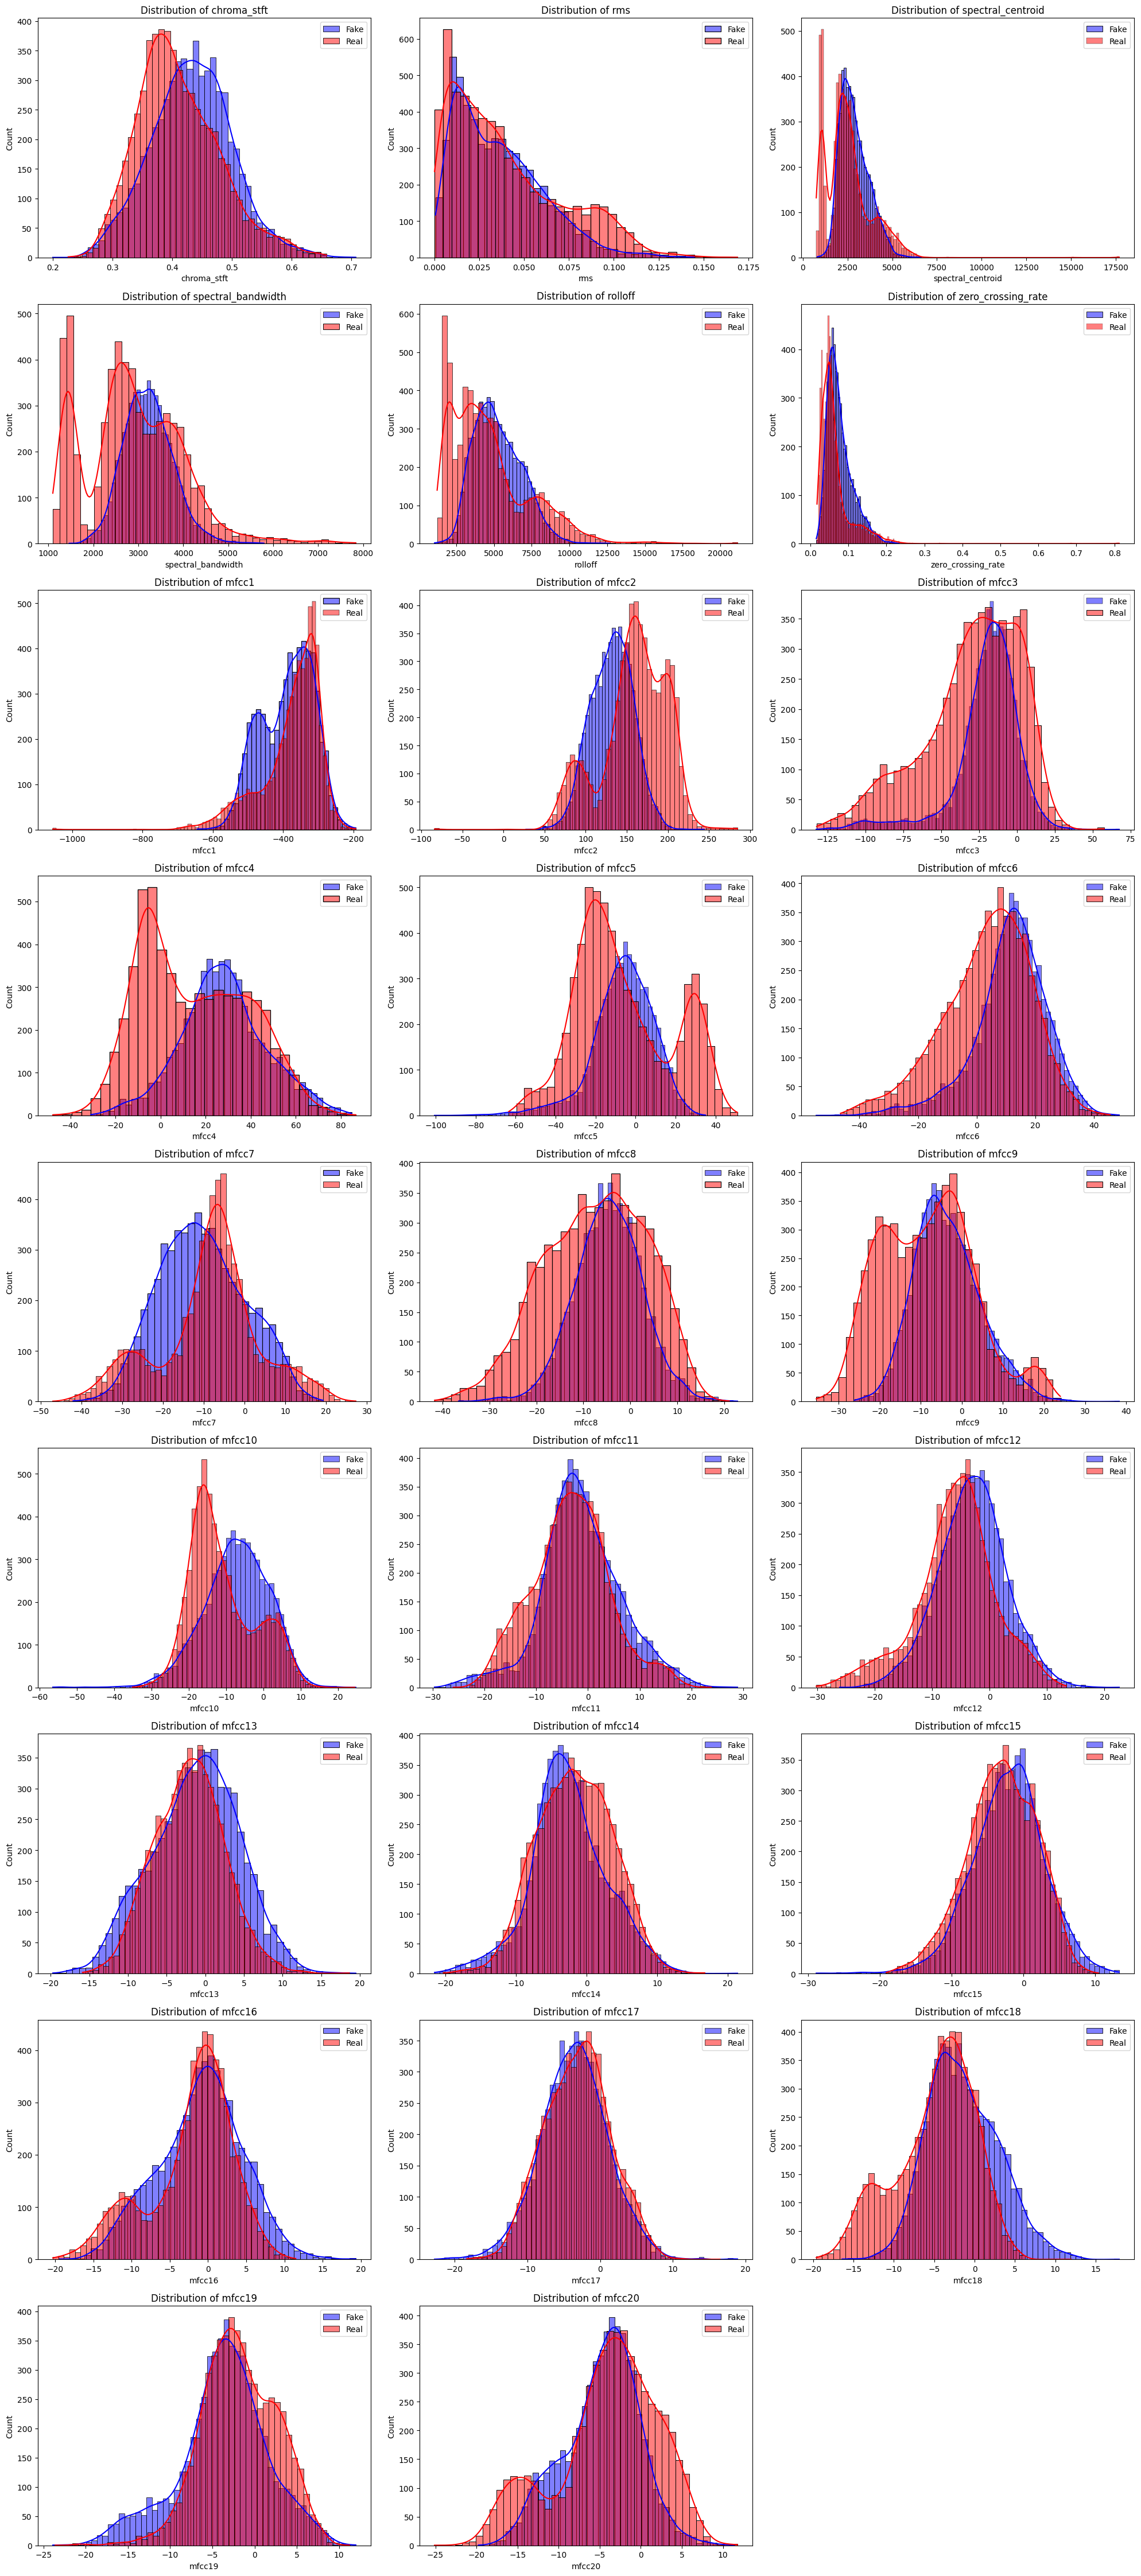

In [ ]:
#Suppress future warnings related to seaborn for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

#Set the number of columns in each row
num_columns = 3

#Total number of tables
num_plots = len(X.columns)

#Calculate the number of lines required
num_rows = (num_plots + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(20, 5 * num_rows))

#Flatten the array of subplots for easier iteration
axes = axes.flatten()

#Loop through each feature column and plot its distribution
for i, column in enumerate(X.columns):
    ax = axes[i]
    sns.histplot(audio_data[audio_data['LABEL'] == 0][column], kde=True, label='Fake', color='blue', ax=ax)
    sns.histplot(audio_data[audio_data['LABEL'] == 1][column], kde=True, label='Real', color='red', ax=ax)
    ax.set_title(f'Distribution of {column}')
    ax.legend()

#Remove Additional Points
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
#Adjust the layout and display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Setting the seed for reproducibility
np.random.seed(23)
tf.random.set_seed(23)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

# Preprocess

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_np = np.array(X_train)
y_train_np = np.array(y_train)
X_test_np = np.array(X_test)
y_test_np = np.array(y_test)

# K-Fold Cross Validation

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_index, val_index in kfold.split(X_train_np, y_train_np):
    X_train_fold, X_val_fold = X_train_np[train_index], X_train_np[val_index]
    y_train_fold, y_val_fold = y_train_np[train_index], y_train_np[val_index]


# RNN

In [ ]:
from keras.regularizers import l2

X_train_fold_rnn = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
X_val_fold_rnn = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

# Build the RNN model
model_rnn = Sequential()
model_rnn.add(LSTM(128, return_sequences=True, input_shape=(X_train_fold.shape[1], 1), kernel_regularizer=l2(0.01)))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01)))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))
model_rnn.add(LSTM(32, return_sequences=False, kernel_regularizer=l2(0.01)))
model_rnn.add(BatchNormalization())
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model
model_rnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    ModelCheckpoint('best_rnn_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5)
]

# Train the model
history_rnn = model_rnn.fit(X_train_fold_rnn, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold_rnn, y_val_fold), callbacks=callbacks)

# Load the best model
model_rnn = tf.keras.models.load_model('best_rnn_model.h5')


Epoch 1/50
236/236 [==============================] - 14s 20ms/step - loss: 1.8017 - accuracy: 0.7656 - val_loss: 1.2016 - val_accuracy: 0.6630
Epoch 2/50
236/236 [==============================] - 3s 12ms/step - loss: 0.7861 - accuracy: 0.8265 - val_loss: 0.7946 - val_accuracy: 0.7564
Epoch 3/50
236/236 [==============================] - 3s 12ms/step - loss: 0.5130 - accuracy: 0.8704 - val_loss: 0.5785 - val_accuracy: 0.8132
Epoch 4/50
236/236 [==============================] - 3s 12ms/step - loss: 0.4141 - accuracy: 0.8827 - val_loss: 0.3515 - val_accuracy: 0.9114
Epoch 5/50
236/236 [==============================] - 3s 13ms/step - loss: 0.3611 - accuracy: 0.8924 - val_loss: 0.3124 - val_accuracy: 0.9151
Epoch 6/50
236/236 [==============================] - 3s 14ms/step - loss: 0.3203 - accuracy: 0.9044 - val_loss: 0.3053 - val_accuracy: 0.9135
Epoch 7/50
236/236 [==============================] - 3s 12ms/step - loss: 0.3123 - accuracy: 0.9029 - val_loss: 0.2975 - val_accuracy: 0.913

# ANN

In [ ]:
# ANN Model
def build_ann_model(input_shape):
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Preparing the data (no reshaping required)
input_shape_ann = (X_train_fold.shape[1],)

model_ann = build_ann_model(input_shape_ann)

callbacks_ann = [
    ModelCheckpoint('best_ann_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5)
]

history_ann = model_ann.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold, y_val_fold), callbacks=callbacks_ann)
model_ann = load_model('best_ann_model.h5')

Epoch 1/50
207/207 [==============================] - 8s 18ms/step - loss: 0.2485 - accuracy: 0.8943 - val_loss: 0.1094 - val_accuracy: 0.9836
Epoch 2/50
207/207 [==============================] - 3s 12ms/step - loss: 0.1083 - accuracy: 0.9606 - val_loss: 0.0445 - val_accuracy: 0.9897
Epoch 3/50
207/207 [==============================] - 2s 11ms/step - loss: 0.0854 - accuracy: 0.9701 - val_loss: 0.0323 - val_accuracy: 0.9897
Epoch 4/50
207/207 [==============================] - 2s 11ms/step - loss: 0.0690 - accuracy: 0.9771 - val_loss: 0.0256 - val_accuracy: 0.9933
Epoch 5/50
207/207 [==============================] - 2s 12ms/step - loss: 0.0618 - accuracy: 0.9789 - val_loss: 0.0231 - val_accuracy: 0.9915
Epoch 6/50
207/207 [==============================] - 2s 9ms/step - loss: 0.0532 - accuracy: 0.9820 - val_loss: 0.0213 - val_accuracy: 0.9927
Epoch 7/50
207/207 [==============================] - 2s 8ms/step - loss: 0.0497 - accuracy: 0.9844 - val_loss: 0.0197 - val_accuracy: 0.9951
E

# CNN

In [ ]:
# Prepare data for the CNN model
X_train_fold_cnn = X_train_fold.reshape((X_train_fold.shape[0], X_train_fold.shape[1], 1))
X_val_fold_cnn = X_val_fold.reshape((X_val_fold.shape[0], X_val_fold.shape[1], 1))

# Build the CNN model
model_cnn = Sequential()
model_cnn.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_fold.shape[1], 1), kernel_regularizer=l2(0.01)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))

model_cnn.add(Conv1D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Dropout(0.3))

model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the CNN model
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks for saving the best model and early stopping
callbacks_cnn = [
    ModelCheckpoint('best_cnn_model.h5', save_best_only=True, monitor='val_loss'),
    EarlyStopping(monitor='val_loss', patience=5)
]

# Train the CNN model
history_cnn = model_cnn.fit(X_train_fold_cnn, y_train_fold, epochs=50, batch_size=32, validation_data=(X_val_fold_cnn, y_val_fold), callbacks=callbacks_cnn)

# Load the best model
model_cnn = tf.keras.models.load_model('best_cnn_model.h5')


Epoch 1/50
236/236 [==============================] - 7s 9ms/step - loss: 1.4920 - accuracy: 0.8047 - val_loss: 1.2923 - val_accuracy: 0.7415
Epoch 2/50
236/236 [==============================] - 2s 8ms/step - loss: 0.8683 - accuracy: 0.8940 - val_loss: 0.6626 - val_accuracy: 0.9315
Epoch 3/50
236/236 [==============================] - 2s 7ms/step - loss: 0.5482 - accuracy: 0.9333 - val_loss: 0.4070 - val_accuracy: 0.9602
Epoch 4/50
236/236 [==============================] - 2s 7ms/step - loss: 0.3894 - accuracy: 0.9459 - val_loss: 0.2835 - val_accuracy: 0.9729
Epoch 5/50
236/236 [==============================] - 3s 12ms/step - loss: 0.3081 - accuracy: 0.9514 - val_loss: 0.2200 - val_accuracy: 0.9814
Epoch 6/50
236/236 [==============================] - 2s 8ms/step - loss: 0.2629 - accuracy: 0.9532 - val_loss: 0.1885 - val_accuracy: 0.9857
Epoch 7/50
236/236 [==============================] - 2s 7ms/step - loss: 0.2378 - accuracy: 0.9561 - val_loss: 0.1840 - val_accuracy: 0.9745
Epoch

#Model Evaluation

In [ ]:
X_test_rnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))
X_test_cnn = X_test_np.reshape((X_test_np.shape[0], X_test_np.shape[1], 1))

rnn_score = model_rnn.evaluate(X_test_rnn, y_test_np)
ann_score = model_ann.evaluate(X_test_np, y_test_np)
cnn_score = model_cnn.evaluate(X_test_cnn, y_test_np)

print(f'RNN Test Accuracy: {rnn_score[1]}')
print(f'ANN Test Accuracy: {ann_score[1]}')
print(f'CNN Test Accuracy: {cnn_score[1]}')

74/74 [==============================] - 1s 4ms/step - loss: 0.1415 - accuracy: 0.9851
RNN Test Accuracy: 0.9885398745536804
ANN Test Accuracy: 0.9966044425964355
CNN Test Accuracy: 0.985144317150116


#Plotting Training Graphs

In [ ]:
def plot_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))


    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title(f'{model_name} Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title(f'{model_name} Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

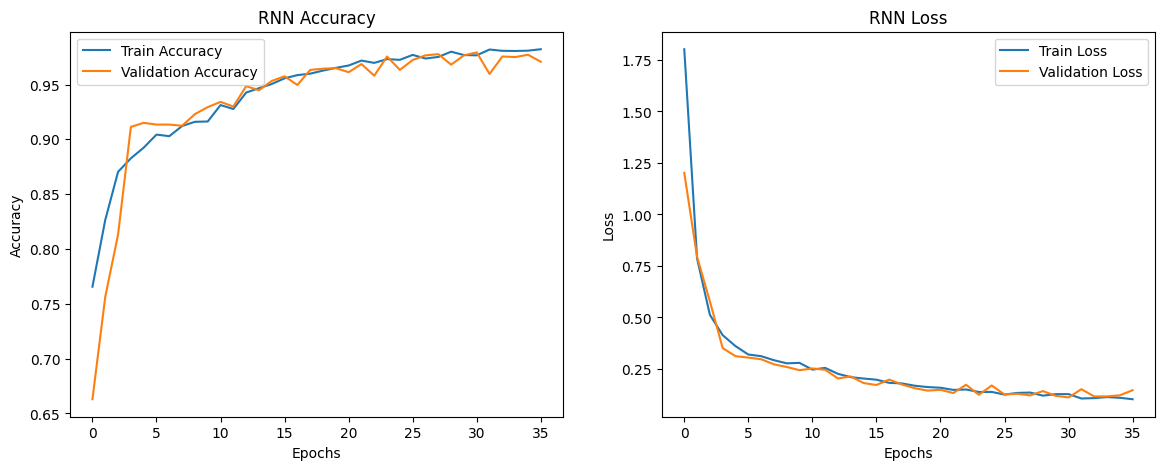

In [ ]:
plot_history(history_rnn, 'RNN')

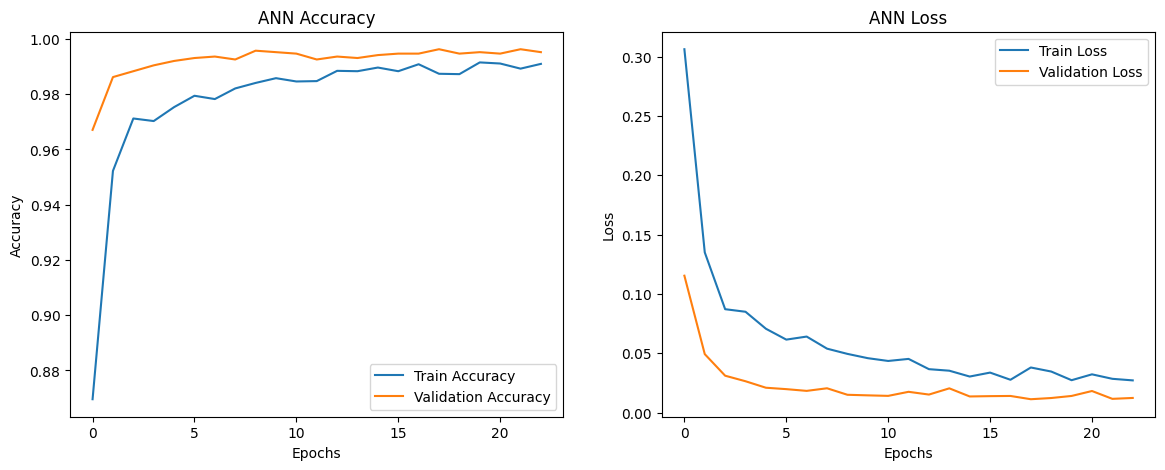

In [ ]:
plot_history(history_ann, 'ANN')

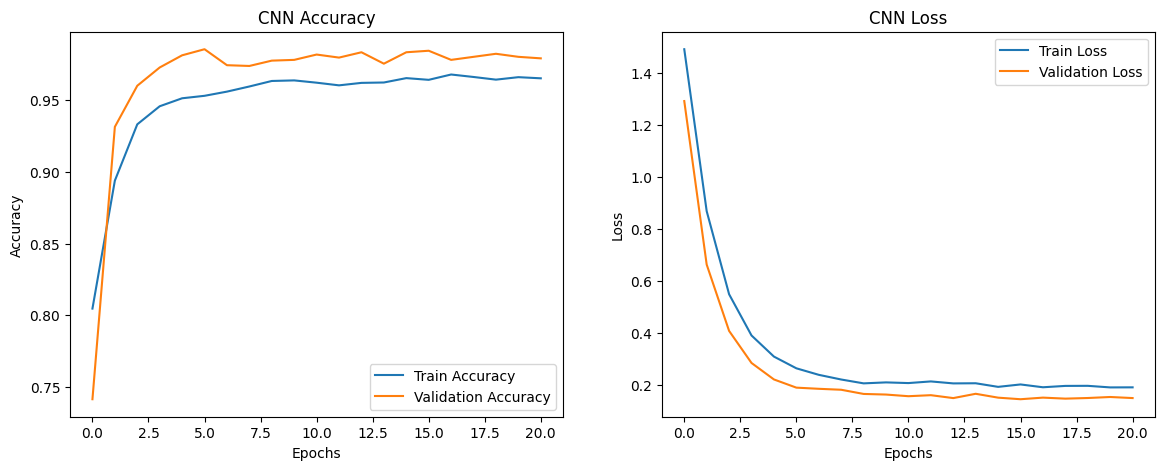

In [ ]:
plot_history(history_cnn, 'CNN')

#Classification Report Evaluation

In [ ]:
y_pred_rnn = (model_rnn.predict(X_test_rnn) > 0.5).astype("int32")
print("RNN Classification Report")
print(classification_report(y_test_np, y_pred_rnn))

74/74 [==============================] - 0s 4ms/step
RNN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1157
           1       0.99      0.99      0.99      1199

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



In [ ]:
y_pred_ann = (model_ann.predict(X_test_np) > 0.5).astype("int32")
print("ANN Classification Report")
print(classification_report(y_test_np, y_pred_ann))

74/74 [==============================] - 0s 2ms/step
ANN Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      1157
           1       1.00      0.99      1.00      1199

    accuracy                           1.00      2356
   macro avg       1.00      1.00      1.00      2356
weighted avg       1.00      1.00      1.00      2356



In [ ]:
y_pred_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")
print("CNN Classification Report")
print(classification_report(y_test_np, y_pred_cnn))

74/74 [==============================] - 0s 3ms/step
CNN Classification Report
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1157
           1       0.98      0.99      0.99      1199

    accuracy                           0.99      2356
   macro avg       0.99      0.99      0.99      2356
weighted avg       0.99      0.99      0.99      2356



#Plotting Confusion Matrix

In [ ]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

74/74 [==============================] - 0s 4ms/step


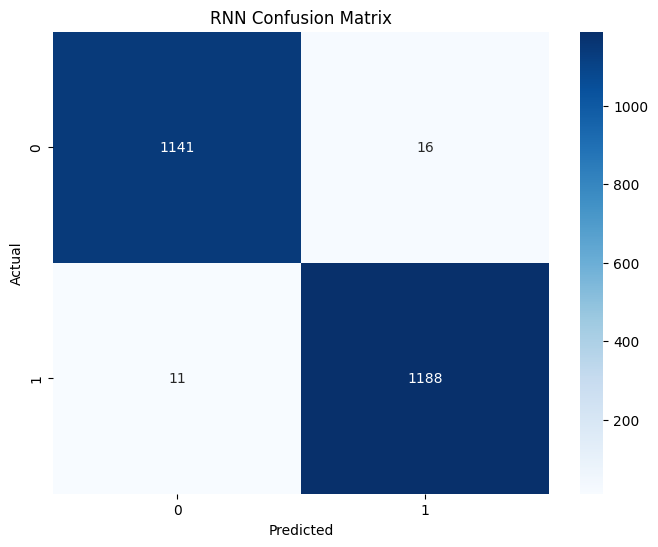

In [ ]:
y_pred_rnn = (model_rnn.predict(X_test_rnn) > 0.5).astype("int32")
plot_confusion_matrix(y_test_np, y_pred_rnn, 'RNN')

74/74 [==============================] - 0s 2ms/step


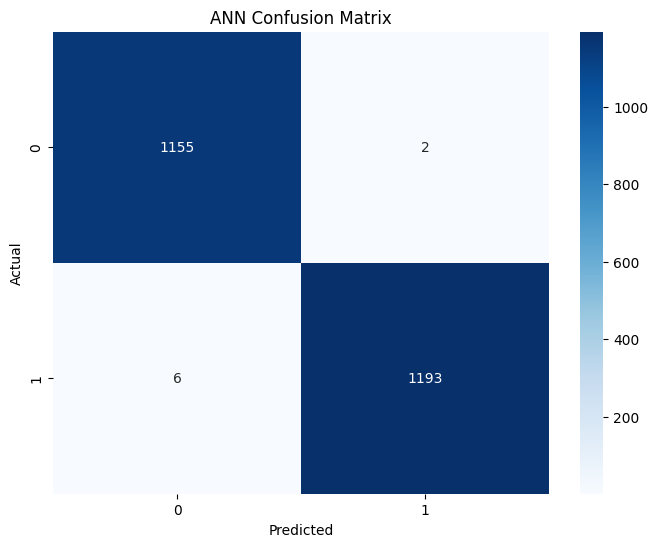

In [ ]:
y_pred_ann = (model_ann.predict(X_test_np) > 0.5).astype("int32")
plot_confusion_matrix(y_test_np, y_pred_ann, 'ANN')

74/74 [==============================] - 0s 2ms/step


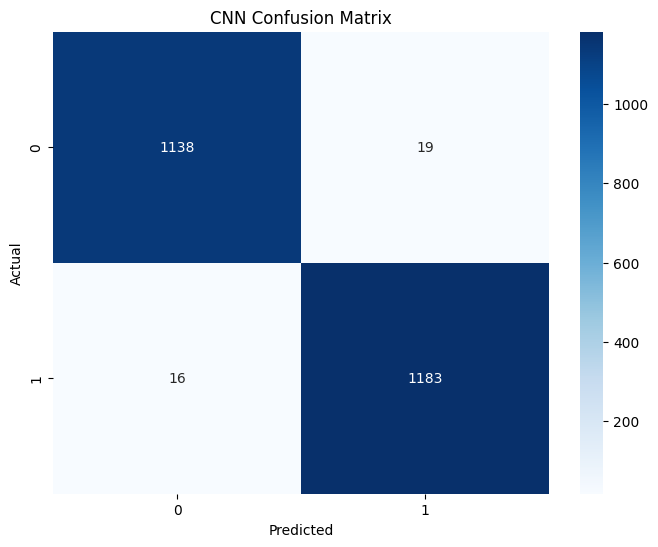

In [ ]:
y_pred_cnn = (model_cnn.predict(X_test_cnn) > 0.5).astype("int32")
plot_confusion_matrix(y_test_np, y_pred_cnn, 'CNN')

#Predicting Audio Files

In [ ]:
real_audio_path = '/content/dataset/KAGGLE/AUDIO/REAL'
fake_audio_path = '/content/dataset/KAGGLE/AUDIO/FAKE'

#Showing files in the real_audio_path path
print("Files in REAL directory:")
for file_name in os.listdir(real_audio_path):
    print(file_name)

Files in REAL directory:
taylor-original.wav
trump-original.wav
linus-original.wav
musk-original.wav
margot-original.wav
ryan-original.wav
biden-original.wav
obama-original.wav


In [ ]:
# Showing files in the fake_audio_path
print("Files in FAKE directory:")
for file_name in os.listdir(fake_audio_path):
    print(file_name)

Files in FAKE directory:
trump-to-Biden.wav
obama-to-musk.wav
linus-to-obama.wav
Obama-to-Trump.wav
trump-to-ryan.wav
trump-to-linus.wav
margot-to-musk.wav
linus-to-musk.wav
musk-to-linus.wav
ryan-to-taylor.wav
trump-to-Obama.wav
musk-to-trump.wav
obama-to-linus.wav
ryan-to-biden.wav
biden-to-taylor.wav
musk-to-biden.wav
linus-to-ryan.wav
linus-to-taylor.wav
ryan-to-linus.wav
musk-to-taylor.wav
musk-to-obama.wav
biden-to-Trump.wav
margot-to-taylor.wav
ryan-to-musk.wav
taylor-to-biden.wav
linus-to-biden.wav
taylor-to-ryan.wav
linus-to-trump.wav
taylor-to-linus.wav
ryan-to-trump.wav
biden-to-ryan.wav
taylor-to-obama.wav
obama-to-ryan.wav
ryan-to-margot.wav
taylor-to-margot.wav
taylor-to-musk.wav
linus-to-margot.wav
margot-to-ryan.wav
musk-to-ryan.wav
margot-to-trump.wav
musk-to-margot.wav
biden-to-linus.wav
trump-to-margot.wav
biden-to-Obama.wav
biden-to-musk.wav
ryan-to-obama.wav
trump-to-musk.wav
trump-to-taylor.wav
obama-to-taylor.wav
margot-to-biden.wav
biden-to-margot.wav
obama-to-m

In [ ]:
# Load models
model_rnn = load_model('/content/best_rnn_model.h5')
model_ann = load_model('/content/best_ann_model.h5')
model_cnn = load_model('/content/best_cnn_model.h5')

# Extract features from audio file
def extract_features(file_path, sr=22050, n_mfcc=26):
    y, sr = librosa.load(file_path, sr=sr)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfccs = np.mean(mfccs.T, axis=0)
    return mfccs

# Predict the audio file
def predict_audio(file_path, model, model_type='rnn'):
    features = extract_features(file_path)
    features = scaler.transform([features])

    if model_type == 'rnn' or model_type == 'cnn':
        features = features.reshape((features.shape[0], features.shape[1], 1))


    prediction = model.predict(features)
    return 'REAL' if prediction[0] > 0.5 else 'FAKE'


In [ ]:
# Example for prediction
real_audio_test = os.path.join(real_audio_path, 'taylor-original.wav')
fake_audio_test = os.path.join(fake_audio_path, 'trump-to-taylor.wav')

print("\033[1mRNN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_rnn, 'rnn')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_rnn, 'rnn')}")

print("\n\033[1mANN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_ann, 'ann')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_ann, 'ann')}")

print("\n\033[1mCNN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_cnn, 'cnn')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_cnn, 'cnn')}")

RNN Model:
1/1 [==============================] - 0s 30ms/step
Prediction for real audio: REAL
1/1 [==============================] - 0s 19ms/step
Prediction for fake audio: REAL

ANN Model:
1/1 [==============================] - 0s 17ms/step
Prediction for real audio: REAL
1/1 [==============================] - 0s 18ms/step
Prediction for fake audio: FAKE

CNN Model:
1/1 [==============================] - 0s 18ms/step
Prediction for real audio: REAL
1/1 [==============================] - 0s 26ms/step
Prediction for fake audio: FAKE


In [ ]:
# Example for prediction
real_audio_test = os.path.join(real_audio_path, 'trump-original.wav')
fake_audio_test = os.path.join(fake_audio_path, 'trump-to-musk.wav')

print("\033[1mRNN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_rnn, 'rnn')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_rnn, 'rnn')}")

print("\n\033[1mANN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_ann, 'ann')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_ann, 'ann')}")

print("\n\033[1mCNN Model:\033[0m")
print(f"Prediction for real audio: {predict_audio(real_audio_test, model_cnn, 'cnn')}")
print(f"Prediction for fake audio: {predict_audio(fake_audio_test, model_cnn, 'cnn')}")

RNN Model:
1/1 [==============================] - 0s 35ms/step
Prediction for real audio: REAL
1/1 [==============================] - 0s 22ms/step
Prediction for fake audio: FAKE

ANN Model:
1/1 [==============================] - 0s 17ms/step
Prediction for real audio: FAKE
1/1 [==============================] - 0s 17ms/step
Prediction for fake audio: FAKE

CNN Model:
1/1 [==============================] - 0s 17ms/step
Prediction for real audio: FAKE
1/1 [==============================] - 0s 17ms/step
Prediction for fake audio: FAKE
